In [1]:
# Imports
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import sys
import os

np.random.seed(42)

In [2]:
# ignore Warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
def transform_numeric_columns(df, exclude_cols):
    # Create a copy of the DataFrame to avoid modifying the original
    df_transformed = df.copy()
    
    # Select only numeric columns
    num_cols = df_transformed.select_dtypes(include=['int64', 'float64']).columns
    
    # Exclude specified columns
    cols_to_transform = [col for col in num_cols if col not in exclude_cols]
    
    # Apply the PowerTransformer with the yeo-johnson method
    pt = PowerTransformer(method='yeo-johnson')
    df_transformed[cols_to_transform] = pt.fit_transform(df_transformed[cols_to_transform])
    
    return df_transformed


In [4]:
def sbgrp_performance(df, groupby_col, label_map):
    """
    This function takes in a DataFrame, a column name and a label map and creates a confusion matrix for each unique value in the specified column.

    :param df: DataFrame containing true labels, predicted labels and groupby column
    :type df: pandas.DataFrame
    :param groupby_col: Column name to group data by
    :type groupby_col: str
    :param label_map: Dictionary that maps integer labels to string labels
    :type label_map: dict
    """
    
    # Get a list of unique values in the specified column
    groups = df[groupby_col].unique()

    # Sort the groups in ascending order
    groups.sort()

    # Create a figure with subplots for each group
    fig, axs = plt.subplots(1, len(groups), figsize=(5 * len(groups), 5))

    # Loop through each group
    for i, group in enumerate(groups):
        # Filter the DataFrame to only include data for the current group
        df_group = df[df[groupby_col] == group]

        # Get the true and predicted labels for the current group
        y_true = df_group['Movement']
        y_pred = df_group['prediction_label']

        # Calculate the confusion matrix for the current group
        cm = confusion_matrix(y_true, y_pred)

        # Convert the confusion matrix to a DataFrame with appropriate column and row labels
        columns = [label_map[i] for i in range(len(label_map))]
        df_cm = pd.DataFrame(cm, columns=columns, index=columns)

        # Create a seaborn heatmap to visualize the confusion matrix on the corresponding subplot
        ax = sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap='Greens', cbar=False, ax=axs[i]) # font size

        # Calculate performance metrics for the current group
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Update the layout of the heatmap to include a title and axis labels
        ax.set_title(f'Confusion Matrix for {groupby_col} {group}\n Accuracy: {acc:.2f}, AUC: {auc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # Show the figure with all subplots
    plt.show()

### Data Import and Preparation

In [5]:
df=pd.read_csv("../Data/FinalDF/FinalDF.csv", encoding="utf-8", sep="~")

In [6]:
# Define the columns you want to exclude
cols_to_exclude = ['Company', 'year', "day", "month", 'Is Trading Day', "day_of_week","day_of_year","quarter", 'cos_day','sin_day']

# Transform the numeric features of the dataset
df = transform_numeric_columns(df, cols_to_exclude)

In [7]:
# convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [8]:
# Map companies and Movement an create inversions for future refference
company_map={'AMAZON': 0, 'APPLE': 1, 'TESLA': 2, 'MICROSOFT':3}
movement_map={"Up":1, "Down":0}

inverted_company_map={v: k for k, v in company_map.items()}
inverted_movement_map={v: k for k, v in movement_map.items()}

df['Company']=df['Company'].map(company_map)

df['Movement']=df['Movement'].map(movement_map)
df['PWD Movement']=df['PWD Movement'].map(movement_map)

In [9]:
# Create a TimeSeriesSplit object with the desired number of splits
val_size=0.3

train_data, val_data = train_test_split(df, test_size=val_size)

In [10]:
target="Movement"

# Drop Close and Movement columns to avoid data leakage
class_df_train=train_data.drop(columns=["Date", 'Close', "Adj Close", "Price Change"])

class_df_val=val_data.drop(columns=["Date", 'Close', "Adj Close", "Price Change"])

## Classification

In [11]:
from pycaret.classification import *

In [12]:
# Create the Classification Experiment Enviroment
setup=setup(class_df_train, target=target, session_id = 124, n_jobs=-1, fold=20, use_gpu=True, feature_selection=True, fix_imbalance=True,
            keep_features=['Company', 'year', "day", "month", "day_of_week", "day_of_year","quarter", 'cos_day','sin_day'])

In [13]:
# Find the top model in terms of auc
top_models = compare_models(n_select = 3, sort = 'acc', include=["knn", "svm", "rf", "et", "xgboost", "lightgbm"])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:38:42
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [14]:
# Tune top 3 models
tuned_top3 = [tune_model(i, optimize = 'acc', early_stopping=True) for i in top_models]

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:53:08
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6759,0.7734,0.7931,0.6667,0.7244,0.3382,0.3458
1,0.8056,0.8745,0.9138,0.7681,0.8346,0.6029,0.6164
2,0.7037,0.7521,0.7931,0.6970,0.7419,0.3975,0.4021
3,0.7222,0.8111,0.8070,0.7077,0.7541,0.4381,0.4431
4,0.6944,0.8111,0.8070,0.6765,0.7360,0.3800,0.3883
5,0.7315,0.8105,0.7895,0.7258,0.7563,0.4585,0.4605
6,0.6822,0.7614,0.7719,0.6769,0.7213,0.3554,0.3596
7,0.7196,0.8025,0.7895,0.7143,0.7500,0.4327,0.4355
8,0.7570,0.8267,0.8246,0.7460,0.7833,0.5083,0.5116


Fitting 20 folds for each of 10 candidates, totalling 200 fits


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:53:22
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6389,0.7655,0.7241,0.6462,0.6829,0.2667,0.2691
1,0.7685,0.8479,0.8793,0.7391,0.8031,0.5273,0.5391
2,0.6852,0.7714,0.7586,0.6875,0.7213,0.3616,0.3639
3,0.7500,0.8149,0.8246,0.7344,0.7769,0.4948,0.4991
4,0.7407,0.8204,0.8421,0.7164,0.7742,0.4745,0.4830
5,0.7037,0.8015,0.7895,0.6923,0.7377,0.4006,0.4052
6,0.6729,0.7632,0.7193,0.6833,0.7009,0.3406,0.3411
7,0.7290,0.8140,0.7895,0.7258,0.7563,0.4523,0.4543
8,0.7009,0.8077,0.7368,0.7119,0.7241,0.3978,0.3981


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 20 folds for each of 10 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
# Ensemble Top Model
#bagged_model=ensemble_model(top_models[0], method = 'Bagging', choose_better=True, optimize='auc')

In [16]:
# Blend top 3 models
#blender = blend_models(top_models, choose_better=True, optimize='auc')

In [17]:
# Find the best model of the classification experiment
best_model=automl(optimize = 'acc')

In [18]:
# Retrain the model with also the test data
final_model=finalize_model(best_model)

# Copy the final Training Results
trainning_results=pull()

In [19]:
# Print the final Training Results
trainning_results.iloc[-2]

Accuracy    0.7172
AUC         0.8125
Recall      0.7786
Prec.       0.7160
F1          0.7454
Kappa       0.4284
MCC         0.4313
Name: Mean, dtype: float64

In [20]:
# Get model parameters
parameters=plot_model(final_model, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


In [21]:
# Use the model to predict on the validation set
predictions = predict_model(final_model, data=class_df_val)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7473,0.8422,0.7898,0.7603,0.7748,0.4873,0.4878


In [22]:
#evaluate_model(final_model)
validaton_results = pull()
validaton_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7473,0.8422,0.7898,0.7603,0.7748,0.4873,0.4878


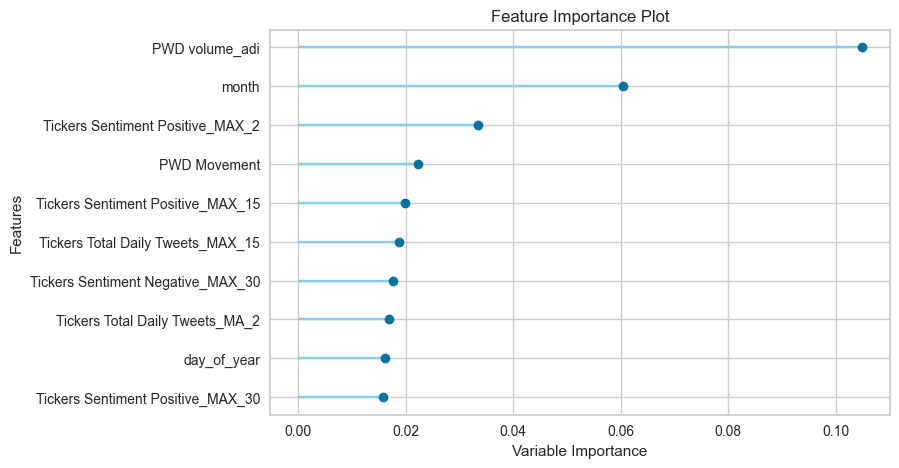

In [23]:
# Plot Feature Importance
plot_model(final_model, plot='feature')

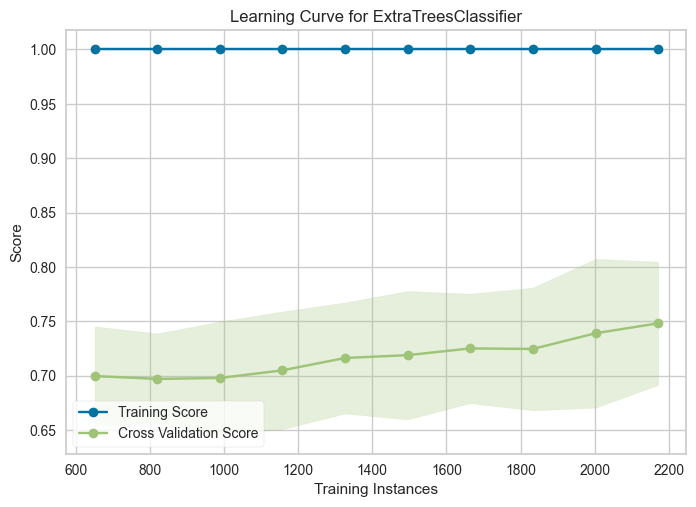

In [24]:
# Plot Precision Recall Curve
plot_model(final_model, plot='learning')

In [25]:
pipeline = final_model
pipeline

Pipeline(memory=FastMemory(location=C:\Users\dimta\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Open', 'Company', 'PWD Open',
                                             'PWD High', 'PWD Low', 'PWD Close',
                                             'PWD Adj Close', 'PWD Volume',
                                             'PWD Price Change', 'PWD Movement',
                                             'PWD volume_adi', 'PWD volume_obv',
                                             'PWD volume_cmf', 'PWD volume_fi',
                                             'PWD volume_em',
                                             'PWD volume_...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=-1,
                                      oob_score=False, random_state=124,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [26]:
predictions=predictions[predictions['Is Trading Day'] == 1]

In [27]:
# Inverse Mapping for Movement and Company collumns for Confusion Matrices
predictions['Company']=predictions['Company'].map(inverted_company_map)

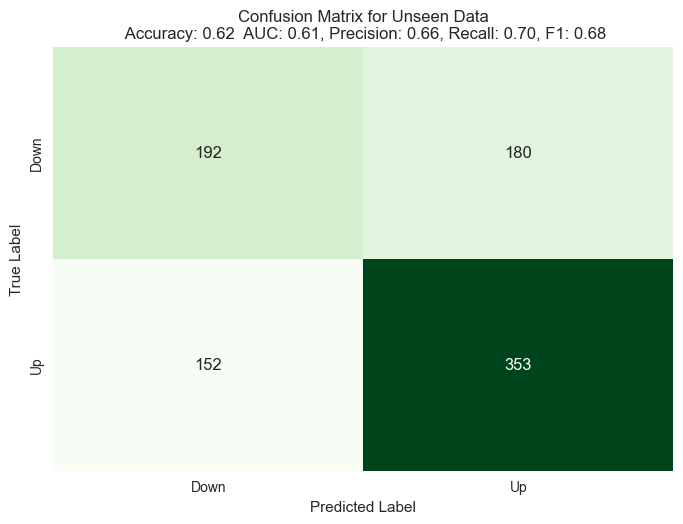

In [28]:
# Plot Confussion Matrix for Unseen Data
# Get the true and predicted labels for the current group
y_true = predictions['Movement']
y_pred = predictions['prediction_label']

# Calculate the confusion matrix for the current group
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm)

# Convert the confusion matrix to a DataFrame with appropriate column and row labels
columns = [inverted_movement_map[i] for i in range(len(inverted_movement_map))]
df_cm = pd.DataFrame(cm, columns=columns, index=columns)

# Calculate performance metrics for the current group
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a seaborn heatmap to visualize the confusion matrix
ax = sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap='Greens', cbar=False)

# Update the layout of the heatmap to include a title and axis labels
ax.set_title(f'Confusion Matrix for Unseen Data\n Accuracy: {acc:.2f}  AUC: {auc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the heatmap
plt.show()

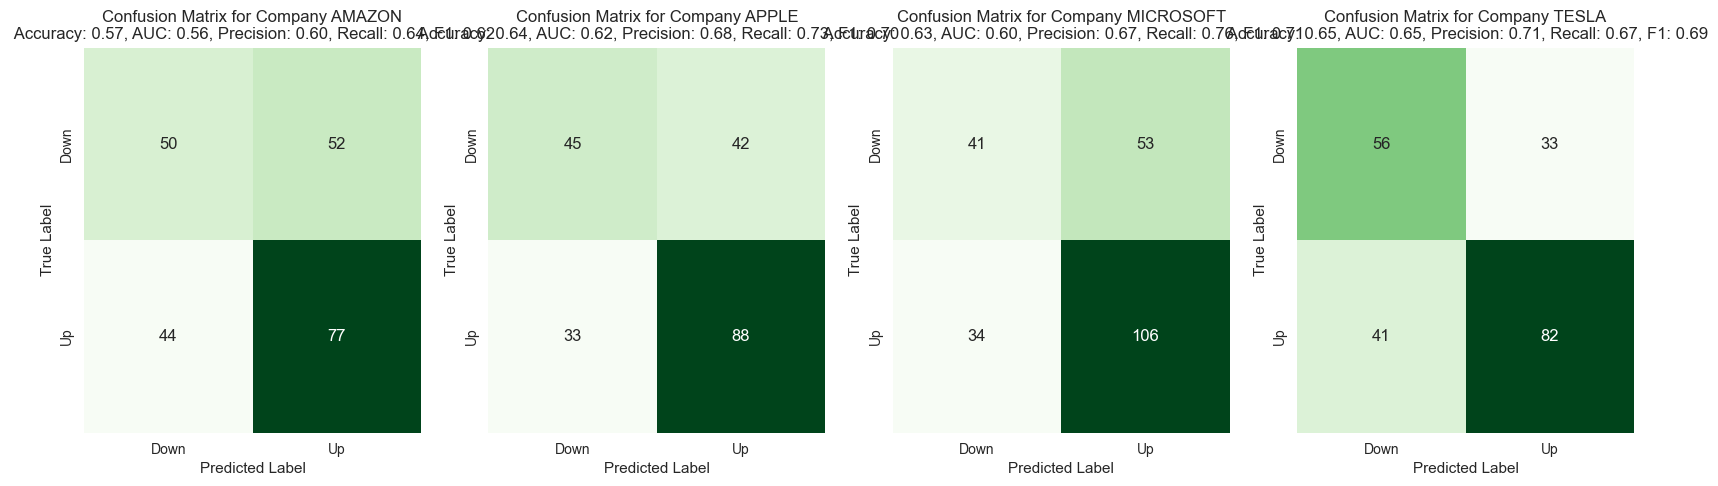

In [29]:
sbgrp_performance(predictions, 'Company', inverted_movement_map)

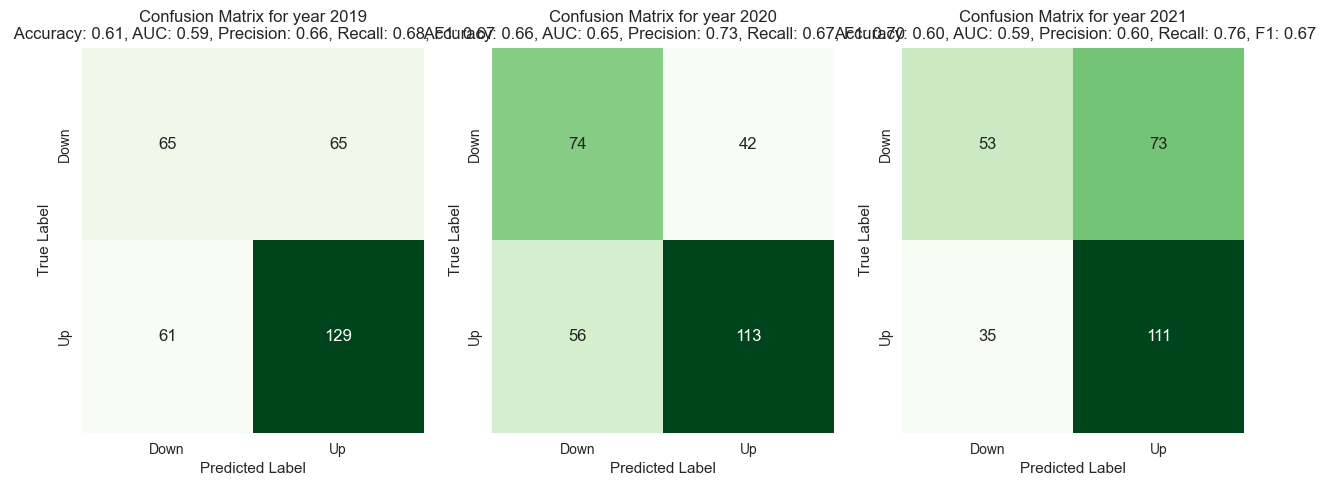

In [30]:
sbgrp_performance(predictions, 'year', inverted_movement_map)

In [31]:
#dashboard(final_model[-1])